# Import Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# scaling and dataset split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# OLS, Ridge
from sklearn.linear_model import LinearRegression, Ridge
# model evaluation
from sklearn.metrics import r2_score, mean_squared_error

# Read the CSV and Perform Basic Data Cleaning

In [3]:
data_to_load = "new_folder/googleplaystore.csv"
df_apps = pd.read_csv(data_to_load)

In [4]:
categories = list(df_apps["Category"].unique())
#Remove Category 1.9
categories.remove('1.9')

a = df_apps.loc[df_apps["Category"] == "1.9"]
df_apps = df_apps.drop(int(a.index.values),axis=0)

#df_apps = df_apps[df_apps['Category']!= "1.9"]

In [5]:
df_apps = df_apps.drop(df_apps[df_apps['Rating'].isnull()].index, axis=0)

In [6]:
df_apps["Type"] = (df_apps["Type"] == "Paid").astype(int)

In [7]:
#Extract App, Installs, & Content Rating from df_apps
popApps = df_apps.copy()
popApps = popApps.drop_duplicates()
#Remove characters preventing values from being floats and integers
popApps["Installs"] = popApps["Installs"].str.replace("+","") 
popApps["Installs"] = popApps["Installs"].str.replace(",","")
popApps["Installs"] = popApps["Installs"].astype("int64")
popApps["Price"] = popApps["Price"].str.replace("$","")
popApps["Price"] = popApps["Price"].astype("float64")
popApps["Size"] = popApps["Size"].str.replace("Varies with device","0")
popApps["Size"] = (popApps["Size"].replace(r'[kM]+$', '', regex=True).astype(float) *\
        popApps["Size"].str.extract(r'[\d\.]+([kM]+)', expand=False).fillna(1).replace(['k','M'], [10**3, 10**6]).astype(int))
popApps["Reviews"] = popApps["Reviews"].astype("int64")

popApps.reset_index(inplace=True)
popApps.drop(["index"],axis=1,inplace=True)

In [8]:
popAppsCopy = popApps.drop(["App","Last Updated","Current Ver","Android Ver","Type"],axis=1)

In [9]:
X = popAppsCopy.drop("Installs", axis = 1)
y = popAppsCopy["Installs"]
y = y.replace({1:'1000+',5: '1000+', 10: '1000+',50:'1000+',100:'1000+',500:'1000+',
               1000: '1000+',5000:'10000+',10000: '10000+', 50000:'100000+',100000:'100000+',
               500000:'1000000+', 1000000:'1000000+',5000000:'10000000+',10000000:'10000000+',
               50000000:'100000000+',100000000:'100000000+', 500000000:'1000000000+', 
               1000000000:'1000000000+' })
print(X.shape, y.shape)

(8892, 7) (8892,)


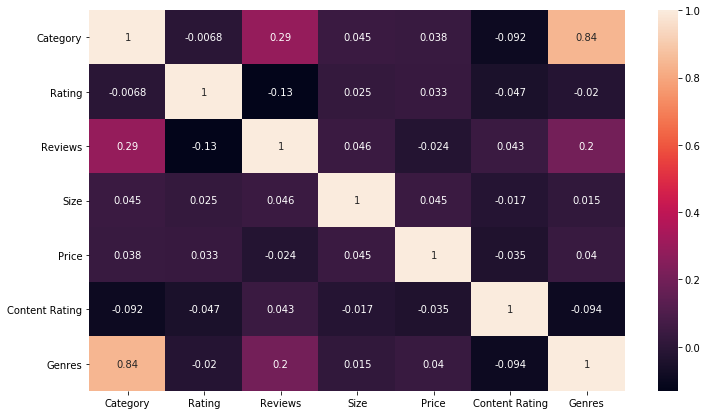

In [10]:
import seaborn as sns
corr = X.apply(lambda x: x.factorize()[0]).corr()
plt.figure(figsize=(12,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True)
plt.savefig('Correlation_matrix.png')

In [11]:
data = popAppsCopy
data = data.drop("Genres",axis =1)
data_binary_encoded = pd.get_dummies(data, columns=["Category"])
data_binary_encoded_1 = pd.get_dummies(data_binary_encoded, columns=["Content Rating"])
data_binary_encoded_1.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4.1,159,19000000.0,10000,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3.9,967,14000000.0,500000,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4.7,87510,8700000.0,5000000,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4.5,215644,25000000.0,50000000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.3,967,2800000.0,100000,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
X = data_binary_encoded_1.drop("Installs", axis = 1)
y = data_binary_encoded_1["Installs"]
y = y.replace({1:'1000+',5: '1000+', 10: '1000+',50:'1000+',100:'1000+',500:'1000+',
               1000: '1000+',5000:'10000+',10000: '10000+', 50000:'100000+',100000:'100000+',
               500000:'1000000+', 1000000:'1000000+',5000000:'10000000+',10000000:'10000000+',
               50000000:'100000000+',100000000:'100000000+', 500000000:'1000000000+', 
               1000000000:'1000000000+' })
print(X.shape, y.shape)

(8892, 43) (8892,)


In [13]:
#X = X.drop(["Content Rating_Adults only 18+","Content Rating_Unrated"], axis = 1)
feature_names = X.columns

In [14]:
feature_names

Index(['Rating', 'Reviews', 'Size', 'Price', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY',
       'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME',
       'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME',
       'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE',
       'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL',
       'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       '

# Split the data into training and testing

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# SVC Model

In [17]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
print('Test Acc: %.3f' % model.score(X_test_scaled, y_test))

Test Acc: 0.305


In [19]:
print(f"Training Data Score: {model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model.score(X_test_scaled, y_test)}")

Training Data Score: 0.2949467686309792
Testing Data Score: 0.3049932523616734


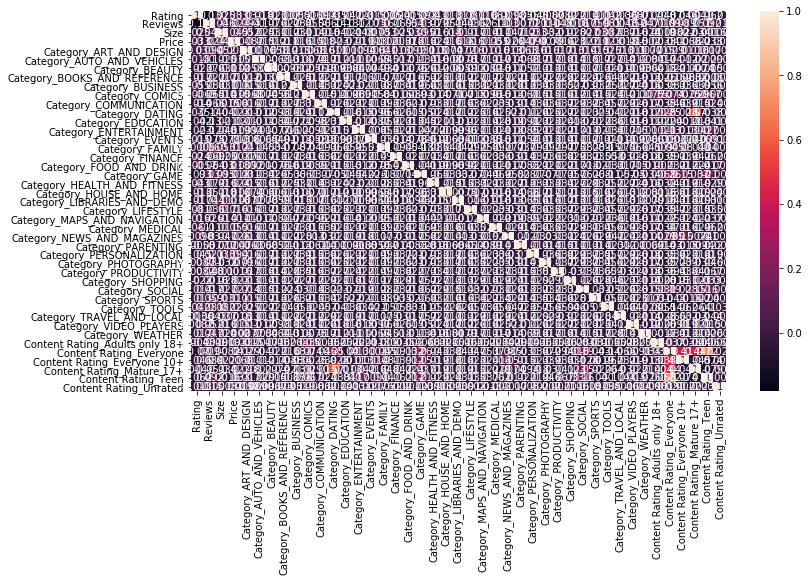

In [22]:
import seaborn as sns
corr = X.apply(lambda x: x.factorize()[0]).corr()
plt.figure(figsize=(12,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True)
plt.savefig('large_cor.png')
plt.show()

# Random Forest Model

In [51]:
from sklearn import tree

In [54]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
print('Test_score:', clf.score(X_test, y_test))
print('Train_score:', clf.score(X_train, y_train))

Test_score: 0.7206477732793523
Train_score: 1.0


In [56]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_scaled, y_train)
print('Test_score:', clf.score(X_test_scaled, y_test))
print('Train_score:', clf.score(X_train_scaled, y_train))

Test_score: 0.7062528115159694
Train_score: 0.9998500524816314


In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
print('Test_score:', rf.score(X_test_scaled, y_test))
print('Train_score:',rf.score(X_train_scaled, y_train))

Test_score: 0.7777777777777778
Train_score: 0.9995501574448943


In [25]:
y_pred = rf.predict(X_test_scaled)

Accuracy 0.7773279352226721


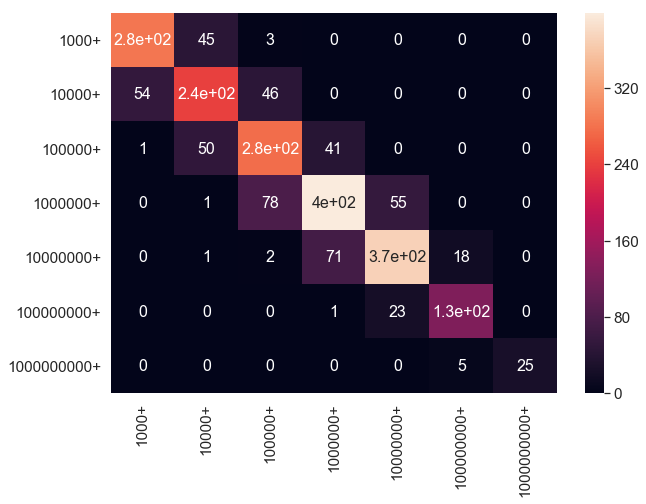

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
print('Accuracy' , accuracy_score(y_test, y_pred))
plt.savefig("correlation_rf.png")

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.7759784075573549

# Hyperparameter Tuning

In [26]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[100,200,300,400,500,600,700,800,900,1000],
              'max_depth':[1,5,10,15,20]}
grid = GridSearchCV(rf,param_grid,verbose=3)

In [27]:
grid.fit(X_train,y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_depth=1, n_estimators=100 ...................................
[CV] ....... max_depth=1, n_estimators=100, score=0.376, total=   0.2s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=100, score=0.304, total=   0.2s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=100, score=0.304, total=   0.2s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] ....... max_depth=1, n_estimators=200, score=0.403, total=   0.4s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] ....... max_depth=1, n_estimators=200, score=0.296, total=   0.4s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] ....... max_depth=1, n_estimators=200, score=0.300, total=   0.4s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] ....... max_depth=1, n_estimators=300, score=0.297, total=   0.7s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] ....... max_depth=1, n_estimators=300, score=0.302, total=   0.6s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] ....... max_depth=1, n_estimators=300, score=0.297, total=   0.6s
[CV] max_depth=1, n_estimators=400 ...................................
[CV] .

[CV] ...... max_depth=10, n_estimators=100, score=0.747, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.734, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.750, total=   0.5s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.751, total=   1.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.732, total=   1.1s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.749, total=   0.9s
[CV] max_depth=10, n_estimators=300 ..................................
[CV] ...... max_depth=10, n_estimators=300, score=0.747, total=   1.3s
[CV] max_depth=10, n_estimators=300 ..................................
[CV] .

[CV] ..... max_depth=15, n_estimators=1000, score=0.759, total=   6.2s
[CV] max_depth=15, n_estimators=1000 .................................
[CV] ..... max_depth=15, n_estimators=1000, score=0.769, total=   6.7s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.766, total=   0.7s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.758, total=   0.8s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.777, total=   0.8s
[CV] max_depth=20, n_estimators=200 ..................................
[CV] ...... max_depth=20, n_estimators=200, score=0.773, total=   1.3s
[CV] max_depth=20, n_estimators=200 ..................................
[CV] ...... max_depth=20, n_estimators=200, score=0.763, total=   1.3s
[CV] max_depth=20, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.9min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             i

In [28]:
# List the best parameters for this dataset
print(grid.best_params_)

{'max_depth': 20, 'n_estimators': 1000}


In [29]:
# List the best score
print(grid.best_score_)

0.7737291947818263


In [30]:
# Create the GridSearchCV model
predictions = grid.predict(X_test)
predictions_train = grid.predict(X_train)

In [31]:
# Train the model with GridSearch
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       1000+       0.88      0.85      0.86       333
      10000+       0.72      0.74      0.73       341
     100000+       0.68      0.77      0.72       369
    1000000+       0.78      0.74      0.76       533
   10000000+       0.83      0.82      0.82       464
  100000000+       0.83      0.82      0.83       153
 1000000000+       1.00      0.63      0.78        30

    accuracy                           0.78      2223
   macro avg       0.82      0.77      0.79      2223
weighted avg       0.79      0.78      0.78      2223



In [32]:
imp_features = sorted(zip(rf.feature_importances_, feature_names), reverse=True)

In [33]:
imp_features

[(0.5664838245377466, 'Reviews'),
 (0.14175675977852592, 'Size'),
 (0.1397142927572787, 'Rating'),
 (0.02566972238590455, 'Price'),
 (0.007957118771776012, 'Category_FAMILY'),
 (0.0078018331530522265, 'Category_GAME'),
 (0.006426521739425671, 'Content Rating_Everyone'),
 (0.005378377628679246, 'Content Rating_Teen'),
 (0.0053280339618318765, 'Category_TOOLS'),
 (0.004955399284827487, 'Category_PRODUCTIVITY'),
 (0.004671775684159063, 'Category_MEDICAL'),
 (0.004267899220891056, 'Category_PHOTOGRAPHY'),
 (0.004184484808347385, 'Category_SPORTS'),
 (0.004165809561903613, 'Category_LIFESTYLE'),
 (0.004139216300084016, 'Category_FINANCE'),
 (0.003924125145622903, 'Category_PERSONALIZATION'),
 (0.0038864193675087204, 'Category_COMMUNICATION'),
 (0.003684985739349767, 'Category_BUSINESS'),
 (0.0036558675320488227, 'Category_VIDEO_PLAYERS'),
 (0.003604561396154394, 'Category_NEWS_AND_MAGAZINES'),
 (0.0035218625966056665, 'Category_HEALTH_AND_FITNESS'),
 (0.003459072477757409, 'Content Rating_M

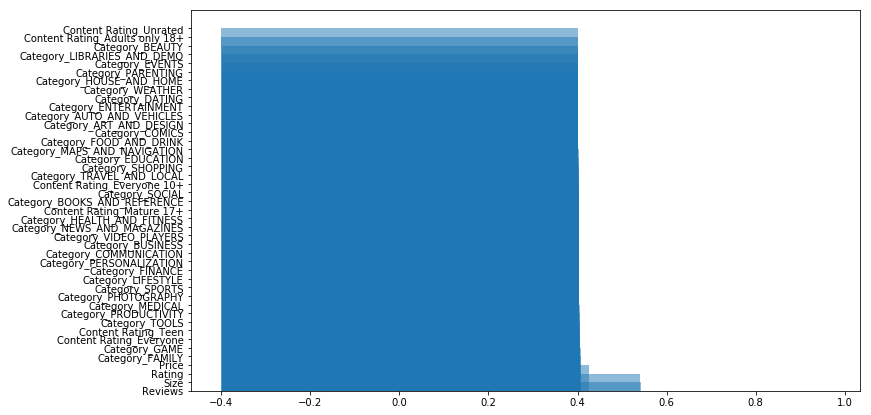

In [36]:
y_v = [lis[0] for lis in imp_features]
x = [lis[1] for lis in imp_features]
plt.figure(figsize=(12,7))
plt.bar(y_v,x, align='center', alpha=0.5)
plt.savefig('Knee_effect.png')

# Remove least imp features

In [38]:
X_red = popAppsCopy.drop(["Genres","Category","Installs","Content Rating","Genres"], axis = 1)
y_red = popApps["Installs"]
y = y_red.replace({1:'1000+',5: '1000+', 10: '1000+',50:'1000+',100:'1000+',500:'1000+',
               1000: '1000+',5000:'10000+',10000: '10000+', 50000:'100000+',100000:'100000+',
               500000:'1000000+', 1000000:'1000000+',5000000:'10000000+',10000000:'10000000+',
               50000000:'100000000+',100000000:'100000000+', 500000000:'1000000000+', 
               1000000000:'1000000000+' })
print(X_red.shape, y_red.shape)

(8892, 4) (8892,)


In [39]:
X_red.head()

,Rating,Reviews,Size,Price
0,4.1,159,19000000.0,0.0
1,3.9,967,14000000.0,0.0
2,4.7,87510,8700000.0,0.0
3,4.5,215644,25000000.0,0.0
4,4.3,967,2800000.0,0.0


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, random_state=42)

In [41]:
from sklearn import tree

In [42]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4903283850652272

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5555555555555556

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.573549257759784

In [49]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[100,200,300,400,500,600,700,800,900,1000],
              'max_depth':[5,10,15,20]}
grid = GridSearchCV(rf,param_grid,verbose=3)

In [50]:
grid.fit(X_train,y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_depth=1, n_estimators=100 ...................................
[CV] ....... max_depth=1, n_estimators=100, score=0.279, total=   0.3s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=100, score=0.270, total=   0.2s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=100, score=0.265, total=   0.2s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] ....... max_depth=1, n_estimators=200, score=0.270, total=   0.5s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] ....... max_depth=1, n_estimators=200, score=0.270, total=   0.5s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] ....... max_depth=1, n_estimators=200, score=0.266, total=   0.4s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] ....... max_depth=1, n_estimators=300, score=0.270, total=   0.7s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] ....... max_depth=1, n_estimators=300, score=0.269, total=   0.7s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] ....... max_depth=1, n_estimators=300, score=0.265, total=   0.8s
[CV] max_depth=1, n_estimators=400 ...................................
[CV] .

[CV] ...... max_depth=10, n_estimators=100, score=0.551, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.547, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.548, total=   0.6s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.550, total=   1.1s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.552, total=   1.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.552, total=   1.0s
[CV] max_depth=10, n_estimators=300 ..................................
[CV] ...... max_depth=10, n_estimators=300, score=0.551, total=   1.6s
[CV] max_depth=10, n_estimators=300 ..................................
[CV] .

[CV] ..... max_depth=15, n_estimators=1000, score=0.535, total=   8.5s
[CV] max_depth=15, n_estimators=1000 .................................
[CV] ..... max_depth=15, n_estimators=1000, score=0.531, total=   8.5s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.541, total=   0.9s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.524, total=   0.9s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.531, total=   0.9s
[CV] max_depth=20, n_estimators=200 ..................................
[CV] ...... max_depth=20, n_estimators=200, score=0.539, total=   1.8s
[CV] max_depth=20, n_estimators=200 ..................................
[CV] ...... max_depth=20, n_estimators=200, score=0.521, total=   1.7s
[CV] max_depth=20, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  7.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             i

In [51]:
# List the best score
print(grid.best_score_)

0.5518068675963412


In [52]:
grid.score(X_train,y_train)

0.6681661418503524

# PCA

In [53]:
X.head()

,Rating,Reviews,Size,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4.1,159,19000000.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3.9,967,14000000.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4.7,87510,8700000.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4.5,215644,25000000.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.3,967,2800000.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [56]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [57]:
explained_variance = pca.explained_variance_ratio_

In [58]:
explained_variance

array([5.74492463e-02, 3.99993756e-02, 3.24094175e-02, 2.95783317e-02,
       2.88044320e-02, 2.79388811e-02, 2.74088619e-02, 2.68969526e-02,
       2.64420332e-02, 2.52002376e-02, 2.47255331e-02, 2.46814660e-02,
       2.46498447e-02, 2.46469484e-02, 2.46256136e-02, 2.45470584e-02,
       2.45123054e-02, 2.44396280e-02, 2.43886655e-02, 2.43371314e-02,
       2.42693968e-02, 2.42134369e-02, 2.41786981e-02, 2.41163297e-02,
       2.40665654e-02, 2.40169513e-02, 2.40005397e-02, 2.39989528e-02,
       2.39920920e-02, 2.39593759e-02, 2.39461729e-02, 2.39302515e-02,
       2.18693102e-02, 2.15624591e-02, 2.01049631e-02, 1.98174162e-02,
       1.89090426e-02, 1.77253903e-02, 1.36867969e-02, 9.95389443e-03,
       1.14876884e-32, 2.45094976e-33, 3.81260822e-34])

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=39)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [60]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.27262507026419336


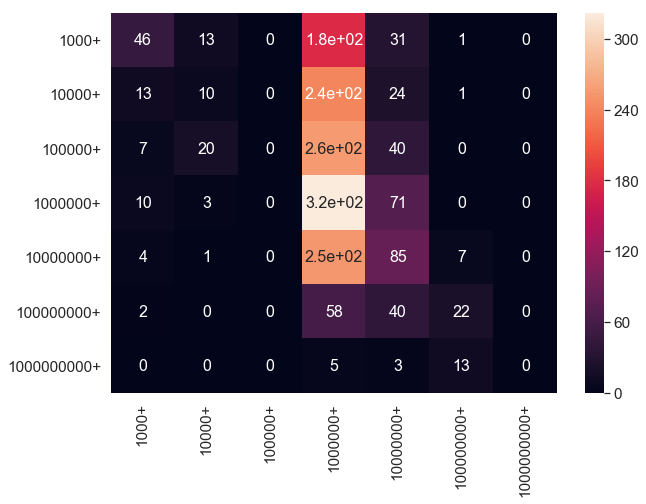

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
print('Accuracy' , accuracy_score(y_test, y_pred))

# Remove the least 2 values from knee effect

In [60]:
X_knee = X.drop(["Content Rating_Adults only 18+","Content Rating_Unrated"], axis = 1)
y_knee = y
print(X_knee.shape, y_knee.shape)

(8892, 41) (8892,)


In [61]:
from sklearn.model_selection import train_test_split

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_knee, y_knee, random_state=42)

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
X_scaler_k = MinMaxScaler().fit(X_train_k)
X_train_scaled_k = X_scaler_k.transform(X_train_k)
X_test_scaled_k = X_scaler_k.transform(X_test_k)

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled_k, y_train_k)
rf.score(X_test_scaled_k, y_test_k)

0.7791273054430949

In [63]:
rf.score(X_train_scaled_k, y_train_k)

0.9998500524816314